# Load Libraries

In [453]:
import pandas as pd
import numpy as np
import random
import os
import datetime
import math

# 시각화 패키지 불러오기
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# EDA
from ydata_profiling import ProfileReport

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


# font
plt.rc('font', family='AppleGothic')

# machine learning
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, MaxAbsScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer


# Fixed Random Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# Load Dataset

In [390]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

display(train_df.head(3))
display(test_df.head(3))

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860


,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Household_Summary,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status
0,TEST_0000,79,M,High Junior,Children or Armed Forces,0,Not in universe or children,Unknown,White,All other,...,Householder,Native,US,Unknown,Unknown,Single,0,0,0,Under Median
1,TEST_0001,47,M,Elementary (5-6),Children or Armed Forces,0,Not in universe or children,Unknown,White,Other Spanish,...,Child 18 or older,Native,US,US,US,Nonfiler,0,0,0,Under Median
2,TEST_0002,18,F,High Junior,Children or Armed Forces,52,Retail,Services,White,All other,...,Child 18 or older,Native,US,US,US,Single,0,0,0,Under Median


In [391]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      20000 non-null  object
 1   Age                     20000 non-null  int64 
 2   Gender                  20000 non-null  object
 3   Education_Status        20000 non-null  object
 4   Employment_Status       20000 non-null  object
 5   Working_Week (Yearly)   20000 non-null  int64 
 6   Industry_Status         20000 non-null  object
 7   Occupation_Status       20000 non-null  object
 8   Race                    20000 non-null  object
 9   Hispanic_Origin         20000 non-null  object
 10  Martial_Status          20000 non-null  object
 11  Household_Status        20000 non-null  object
 12  Household_Summary       20000 non-null  object
 13  Citizenship             20000 non-null  object
 14  Birth_Country           20000 non-null  object
 15  Bi

In [392]:
train_df.describe(include='all')

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
count,20000,20000.000000,20000,20000,20000,20000.000000,20000,20000,20000,20000,...,20000,20000,20000,20000,20000,20000.000000,20000.000000,20000.000000,20000,20000.000000
unique,20000,NaN,2,17,8,NaN,24,15,5,10,...,5,43,43,43,6,NaN,NaN,NaN,3,NaN
top,TRAIN_00000,NaN,F,High graduate,Children or Armed Forces,NaN,Not in universe or children,Unknown,White,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),NaN,NaN,NaN,Under Median,NaN
freq,1,NaN,10472,6494,11142,NaN,4688,4688,16845,17769,...,17825,17825,16563,16594,8588,NaN,NaN,NaN,13237,NaN
mean,NaN,35.632500,NaN,NaN,NaN,34.943050,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,383.129500,40.202150,123.451450,NaN,554.565250
std,NaN,17.994414,NaN,NaN,NaN,22.254592,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4144.247487,279.182677,1206.949429,NaN,701.553155
min,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000
25%,NaN,23.000000,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,0.000000
50%,NaN,34.000000,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,500.000000
75%,NaN,47.000000,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,875.000000


In [393]:
# 결측치 확인
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 1)

In [394]:
# Pandas Profiling
profile = ProfileReport(train_df, title="Profiling Report")

In [395]:
# profile.to_notebook_iframe()

# EDA 방향성

1. 변수들 간 서로 영향을 강력하게 미치는 것들이 많을 것으로 생각됨. 예를 들어 학력은 job을 구했는지, 일하는 시간 등에 영향을 미칠 것이며, 국가와 인종 관련된 변수도 묶을 수 있을 것이므로, 우선 모델을 돌려보고 변수간 상관관계와 importance를 확인하면서 다중공선성을 제거시켜 나가야 할 듯.
2. 직접적인 영향을 미치는 변수(근로시간, gain, losses, dividens 등)와 간접적인 영향을 미치는 변수(학력, 직업 등) 구분. 가중치를 주면 좋을지?
3. 일단 하나씩 싹 다 보자


# Corr

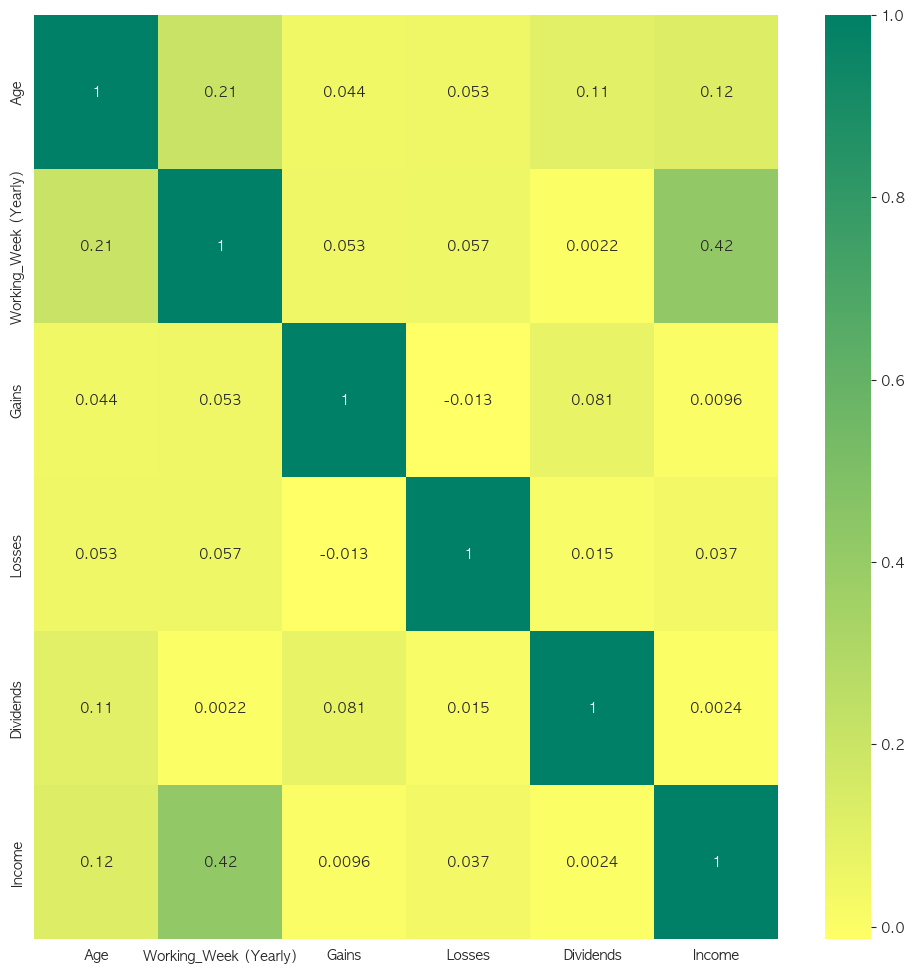

In [396]:
plt.figure(figsize=(12, 12), dpi=100)
sns.heatmap(train_df.corr(), annot=True, cmap="summer_r")
plt.show()

# EDA

In [397]:
train_df.columns

Index(['ID', 'Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

## Age

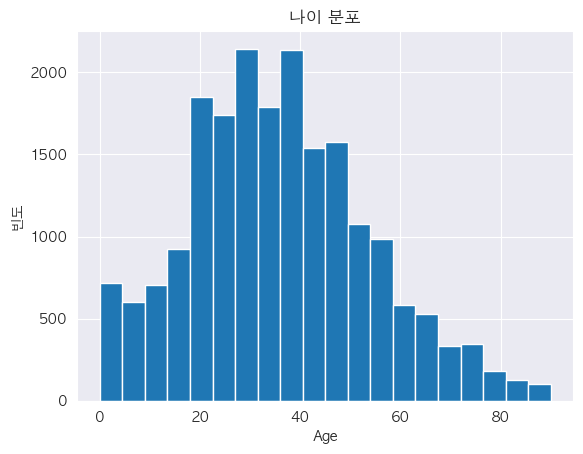

In [398]:
plt.hist(train_df['Age'], bins=20)
plt.xlabel('Age')
plt.ylabel('빈도')
plt.title('나이 분포')
plt.show()

## Gender

In [399]:
gender_counts = train_df.groupby('Gender').size()
gender_counts

Gender
F    10472
M     9528
dtype: int64

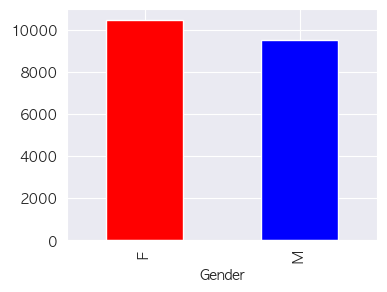

In [400]:
fig, ax = plt.subplots(figsize=(4, 3))
gender_counts.plot(kind='bar', color=['red', 'blue'])
plt.show()

- 특별히 남녀 차이는 보이지 않음. 굳이 나눈다면 결혼 여부에 따라 일을 그만두느냐를 볼 수 있을 것 같은데 결혼 데이터는 해당 데이터셋에 없음.

## Education_Status

In [401]:
education_counts = train_df.groupby('Education_Status').size()
education_counts

Education_Status
Associates degree (Academic)       609
Associates degree (Vocational)     741
Bachelors degree                  1956
Children                          2208
College                           3794
Doctorate degree                    87
Elementary (1-4)                   150
Elementary (5-6)                   317
High Freshman                      555
High Junior                        820
High Senior                        242
High Sophomore                     799
High graduate                     6494
Kindergarten                        64
Masters degree                     505
Middle (7-8)                       548
Professional degree                111
dtype: int64

<Axes: xlabel='Education_Status'>

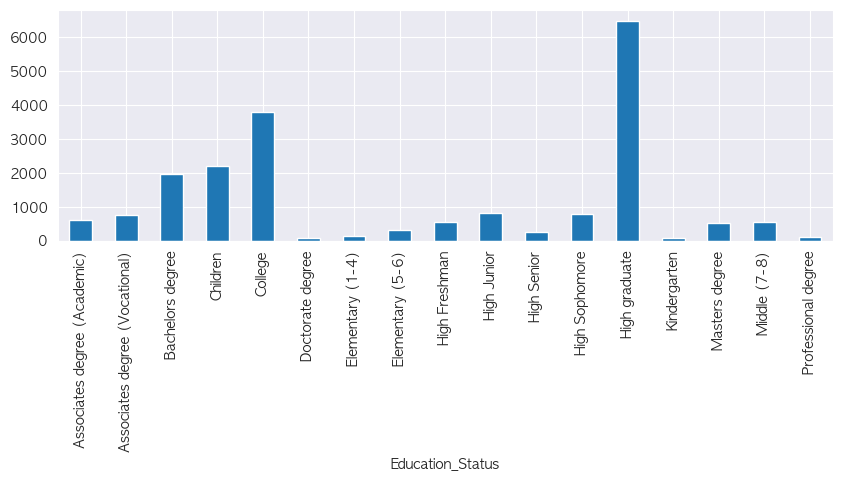

In [402]:
fig, ax = plt.subplots(figsize=(10, 3))
education_counts.plot(kind='bar')

<Axes: xlabel='Education_Status', ylabel='Income'>

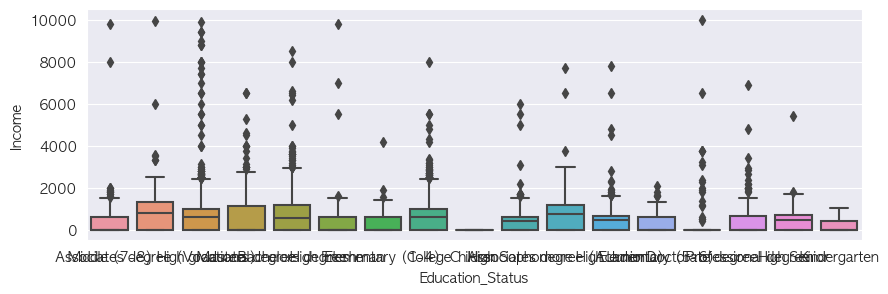

In [403]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(x='Education_Status', y='Income', data=train_df)

- 소득 분석에서는 고졸, 학사, 석사, 박사 수준으로만 구분되는 것이 더 성능이 좋을 것으로 예상

In [404]:
education_counts

Education_Status
Associates degree (Academic)       609
Associates degree (Vocational)     741
Bachelors degree                  1956
Children                          2208
College                           3794
Doctorate degree                    87
Elementary (1-4)                   150
Elementary (5-6)                   317
High Freshman                      555
High Junior                        820
High Senior                        242
High Sophomore                     799
High graduate                     6494
Kindergarten                        64
Masters degree                     505
Middle (7-8)                       548
Professional degree                111
dtype: int64

** 번역
Associates degree (Academic): 학사 학위 (전문)
Associates degree (Vocational): 학사 학위 (전문 직업교육)
Bachelors degree: 학사 학위
Children: 아이들
College: 대학
Doctorate degree: 박사 학위
Elementary (1-4): 초등학교 (1-4학년)
Elementary (5-6): 초등학교 (5-6학년)
High Freshman: 고등학교 신입생
High Junior: 고등학교 3학년생

- 아이들+초딩+고딩, 전문 학사, 전문 직업교육 학사, 학사, 박사 정도?

## Employment_Status

In [405]:
employment_counts = train_df.groupby('Employment_Status').size()
employment_counts

Employment_Status
Children or Armed Forces         11142
Choice Part-Time                   593
Full-Time                         6588
Not Working                       1221
Part-Time (Usually Full-Time)      100
Part-Time (Usually Part-Time)      158
Seeking Full-Time                  121
Seeking Part-Time                   77
dtype: int64

<Axes: xlabel='Employment_Status'>

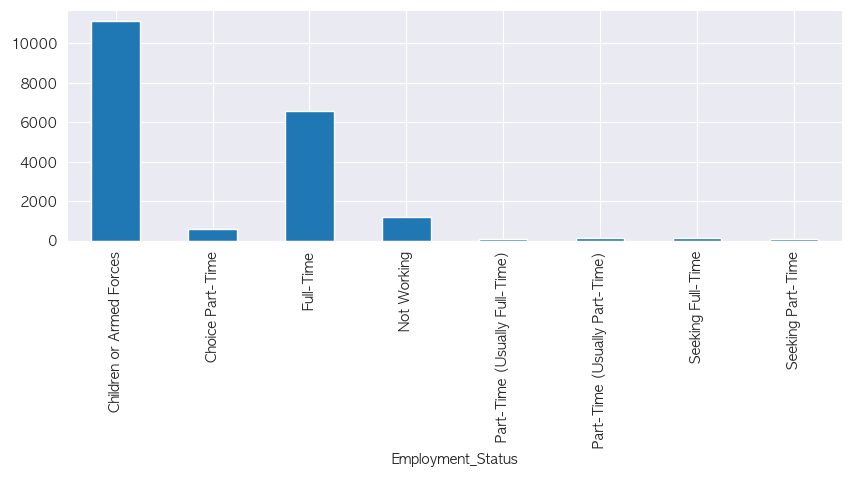

In [406]:
fig, ax = plt.subplots(figsize=(10, 3))
employment_counts.plot(kind='bar')

<Axes: xlabel='Employment_Status', ylabel='Income'>

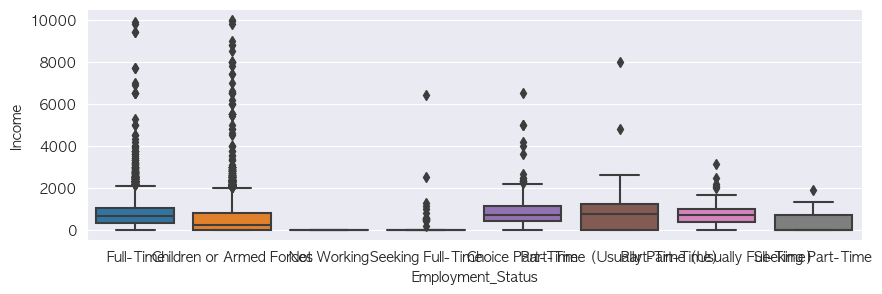

In [407]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(x='Employment_Status', y='Income', data=train_df)

In [408]:
train_df.groupby('Employment_Status')['Income'].mean()

Employment_Status
Children or Armed Forces         488.226979
Choice Part-Time                 792.866779
Full-Time                        746.928051
Not Working                        0.000000
Part-Time (Usually Full-Time)    757.970000
Part-Time (Usually Part-Time)    877.905063
Seeking Full-Time                146.595041
Seeking Part-Time                367.584416
Name: Income, dtype: float64

- Part-Time이라고 해서 딱히 소득 평균이 낮은 건 아님
- Seeking이랑 Part-time만 합치면 되지 않을까 함

## Working_Week (Yearly)

In [409]:
train_df['Working_Week (Yearly)'].describe()

count    20000.000000
mean        34.943050
std         22.254592
min          0.000000
25%          7.000000
50%         52.000000
75%         52.000000
max         52.000000
Name: Working_Week (Yearly), dtype: float64

<Axes: xlabel='Working_Week (Yearly)', ylabel='Income'>

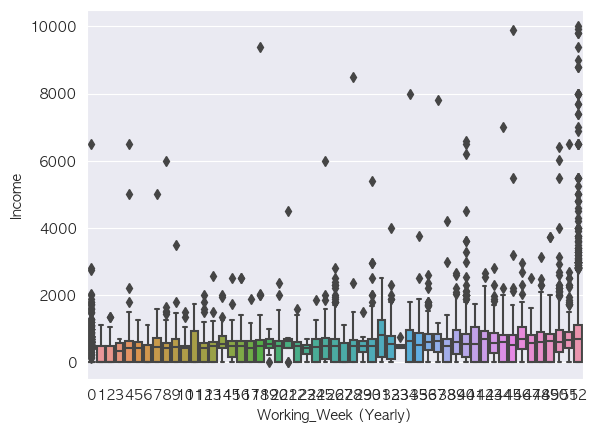

In [410]:
sns.boxplot(x='Working_Week (Yearly)', y='Income', data=train_df)

- 이미 숫자형이고 주당 일한시간은 소득과 선형 상관관계를 가질 것이므로 별도 전처리 필요 없음

## Industry_Status

In [411]:
train_df['Industry_Status']

0                    Social Services
1                      Entertainment
2        Manufacturing (Non-durable)
3                             Retail
4                             Retail
                    ...             
19995        Manufacturing (Durable)
19996                      Education
19997                 Transportation
19998    Not in universe or children
19999          Public Administration
Name: Industry_Status, Length: 20000, dtype: object

In [412]:
train_df.groupby('Industry_Status')['Income'].mean()

Industry_Status
Agriculture                                      434.630597
Armed Forces                                       0.000000
Business & Repair                                646.846517
Communications                                   952.835897
Construction                                     887.155048
Education                                        616.393852
Entertainment                                    703.643885
Finance Insurance & Real Estate                  625.617607
Forestry & Fisheries                             592.038462
Hospitals                                       1040.193666
Manufacturing (Durable)                          907.412063
Manufacturing (Non-durable)                      739.130826
Medical (except Hospitals)                       718.083532
Mining                                           975.700935
Not in universe or children                        0.000000
Other professional services                      747.366876
Personal Services (excep

- 산업 구분은 그냥 전처리만 해주면 될 듯 함.

## Occupation_Status

In [413]:
train_df['Occupation_Status']

0                                Services
1                                Services
2        Admin Support (include Clerical)
3                   Technicians & Support
4                                   Sales
                       ...               
19995                   Handlers/Cleaners
19996    Admin Support (include Clerical)
19997               Technicians & Support
19998                             Unknown
19999    Admin Support (include Clerical)
Name: Occupation_Status, Length: 20000, dtype: object

In [414]:
train_df.groupby('Occupation_Status')['Income'].mean()

Occupation_Status
Admin Support (include Clerical)     750.374677
Armed Forces                           0.000000
Craft & Repair                       986.415730
Farming & Forestry & Fishing         477.922297
Handlers/Cleaners                    655.152927
Machine Operators & Inspectors       802.055676
Management                           619.179118
Private Household Services           420.857143
Professional                         884.705645
Protective Services                  823.511538
Sales                                488.010638
Services                             512.062257
Technicians & Support               1002.417563
Transportation                       846.002899
Unknown                                0.000000
Name: Income, dtype: float64

## Race

In [415]:
train_df['Race'].unique()

array(['White', 'Black', 'Native American/Aleut/Eskimo', 'Asian/Pacific',
       'Other'], dtype=object)

In [416]:
train_df.groupby('Race')['ID'].count()

Race
Asian/Pacific                     511
Black                            2122
Native American/Aleut/Eskimo      226
Other                             296
White                           16845
Name: ID, dtype: int64

## Hispanic_Origin

In [417]:
train_df.groupby('Hispanic_Origin')['ID'].count()

Hispanic_Origin
 All other                    17769
 Central or South American      325
 Chicano                         27
 Cuban                           76
 Do not know                     22
 Mexican (Mexicano)             624
 Mexican-American               654
 NA                              59
 Other Spanish                  201
 Puerto Rican                   243
Name: ID, dtype: int64

- 그냥 Race만 구분하면 될 것 같은데, 굳이 hispac까지 세부적으로 구분하는 게 성능이 좋은지 feature_importance 확인 필요 

## Martial_Status

In [418]:
train_df.groupby('Martial_Status')['ID'].count()

Martial_Status
Divorced                        1633
Married                         9554
Married (Armed Force Spouse)      70
Married (Spouse Absent)          171
Separated                        436
Single                          7380
Widowed                          756
Name: ID, dtype: int64

## Household_Status

In [419]:
train_df.groupby('Household_Status')['ID'].count()


Household_Status
Child 18+ ever marr Not in a subfamily                                     118
Child 18+ ever married Responsible Person of subfamily                     101
Child 18+ never marr Not in a subfamily                                   1860
Child 18+ never married Responsible Person of subfamily                     96
Child 18+ spouse of subfamily Responsible Person                            16
Child <18 ever marr not in subfamily                                         3
Child <18 ever married Responsible Person of subfamily                       1
Child <18 never marr not in subfamily                                     2670
Child <18 never married Responsible Person of subfamily                      8
Child under 18 of Responsible Person of unrelated subfamily                 39
Grandchild 18+ ever marr not in subfamily                                    3
Grandchild 18+ ever married Responsible Person of subfamily                  1
Grandchild 18+ never marr not in su

- 부양가족이 있는 경우 소득이 더 높은 것은 아니지만, 소득이 '더 높아야 하기 때문에' 상관관계가 있을 것으로 추정

## Household_Summary

In [420]:
train_df.groupby('Household_Summary')['ID'].count()

Household_Summary
Child 18 or older                       2192
Child under 18 ever married                4
Child under 18 never married            2679
Group Quarters- Secondary individual      24
Householder                             8552
Nonrelative of householder               974
Other relative of householder            781
Spouse of householder                   4794
Name: ID, dtype: int64

## Citizenship

In [421]:
train_df.groupby('Citizenship')['ID'].count()


Citizenship
Foreign-born (Naturalized US Citizen)            588
Foreign-born (Non-US Citizen)                   1258
Native                                         17825
Native (Born Abroad)                             197
Native (Born in Puerto Rico or US Outlying)      132
Name: ID, dtype: int64

## Birth_Country

In [422]:
train_df.groupby('Birth_Country')['ID'].count()

Birth_Country
Cambodia                            8
Canada                             75
China                              28
Columbia                           36
Cuba                               58
Dominican-Republic                 49
Ecuador                            31
El-Salvador                        68
England                            47
France                             14
Germany                            90
Greece                             13
Guatemala                          28
Haiti                              25
Holand-Netherlands                  3
Honduras                           14
Hong Kong                          16
Hungary                             4
India                              55
Iran                               24
Ireland                            21
Italy                              35
Jamaica                            45
Japan                              30
Laos                               11
Mexico                            54

- 선진국과 후진국 정도로 나누면 되지 않을지..?

## Birth_Country (Father) 

In [423]:
train_df.groupby('Birth_Country (Father)')['ID'].count()

Birth_Country (Father)
Cambodia                           13
Canada                            128
China                              69
Columbia                           45
Cuba                               78
Dominican-Republic                 99
Ecuador                            42
El-Salvador                        83
England                            69
France                             17
Germany                            92
Greece                             33
Guatemala                          33
Haiti                              37
Holand-Netherlands                  5
Honduras                           12
Hong Kong                           8
Hungary                            22
India                              68
Iran                               25
Ireland                            47
Italy                             197
Jamaica                            56
Japan                              28
Laos                               12
Mexico                     

## Birth_Country (Mother)

In [424]:
train_df.groupby('Birth_Country (Mother)')['ID'].count()

Birth_Country (Mother)
Cambodia                           11
Canada                            159
China                              60
Columbia                           45
Cuba                               73
Dominican-Republic                 75
Ecuador                            44
El-Salvador                        99
England                            88
France                             25
Germany                           117
Greece                             23
Guatemala                          36
Haiti                              34
Holand-Netherlands                  4
Honduras                           17
Hong Kong                          10
Hungary                            18
India                              67
Iran                               26
Ireland                            58
Italy                             152
Jamaica                            56
Japan                              37
Laos                                8
Mexico                     

- 결국 이 엄마아빠의 국적 데이터는 그냥 국적 데이터랑 연결이 되어 있을 것임

## Tax_Status

In [425]:
train_df.groupby('Tax_Status')['ID'].count()

Tax_Status
Head of Household (HOH)                                     1217
Married Filling Jointly both over 65 (MFJ)                   469
Married Filling Jointly both under 65 (MFJ)                 8588
Married Filling Jointly one over 65 & one under 65 (MFJ)     305
Nonfiler                                                    3874
Single                                                      5547
Name: ID, dtype: int64

## Gains

In [426]:
train_df.groupby('Gains')['ID'].count()

Gains
0        19217
114          4
401          2
594          7
914          5
         ...  
18481        1
20051        9
25124        3
27828        7
99999       30
Name: ID, Length: 106, dtype: int64

In [427]:
train_df['Gains'].describe()

count    20000.000000
mean       383.129500
std       4144.247487
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: Gains, dtype: float64

## Losses

In [428]:
train_df.groupby('Losses')['ID'].count()

Losses
0       19568
155         1
213         6
323         3
419         1
        ...  
2824        1
3175        1
3770        1
3900        1
4356        2
Name: ID, Length: 86, dtype: int64

In [429]:
train_df['Losses'].describe()

count    20000.000000
mean        40.202150
std        279.182677
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: Losses, dtype: float64

In [430]:
## Dividends

In [431]:
## Income_Status

In [432]:
## Income

# EDA 결론

1. Age : 처리 없음
2. Gender : M, F One-hot Encoding
3. Education_Status : children+Elementary (1-4)+Elementary (5-6)+High Freshman+High Junior, 나머지 그대로, Labelencoder
4. Employment_Status : 일단 그대로 돌려보고 Seeking 2r개 합치거나, Part-Time 2개 합치는 방향으로, OHE
5. Working_Week (Yearly) : 그대로
6. Industry_Status : OHE
7. Occupation_Status : OHE
8. Race : OHE
9. Hispanic_Origin : 돌려보고 아예 변수 삭제, OHE
10. Martial_Status : Armed Force Spouse는 Married로, Spouse Absent는 Widowed로 합치는 것을 검토, 우선 그냥 학습, OHE
11. Household_Status : 일단 그대로, OHE
12. Household_Summary : 일단 그대로, OHE
13. Citizenship : 일단 그대로, OHE
14. Birth_Country :  일단 그대로, OHE
15. Birth_Country (Father) : Feature Importance 보고 삭제
16. Birth_Country (Mother) : Feature Importance 보고 삭제
17. Tax_Status : OHE
18. Gains, Losses, Dividends : 처리 없음
19. Income_Status : OHE

# 데이터 전처리 : 컬럼 삭제

In [433]:
train_df = train_df.drop(columns=['ID','Hispanic_Origin','Birth_Country (Father)','Birth_Country (Mother)','Household_Summary','Gender','Citizenship', 'Tax_Status'], axis=1)
test_df = test_df.drop(columns=['ID','Hispanic_Origin','Birth_Country (Father)','Birth_Country (Mother)','Household_Summary','Gender','Citizenship','Tax_Status'], axis=1)

# Feature Engineering

# One Hot Encoding

In [434]:
# OneHotEncoder 객체 생성
encoder = OneHotEncoder()

In [435]:
encoding_target = pd.DataFrame(train_df[train_df.select_dtypes(include=['object']).columns])
encoding_target

,Education_Status,Employment_Status,Industry_Status,Occupation_Status,Race,Martial_Status,Household_Status,Birth_Country,Income_Status
0,Middle (7-8),Full-Time,Social Services,Services,White,Married,Householder,US,Unknown
1,Associates degree (Vocational),Full-Time,Entertainment,Services,White,Separated,Nonfamily householder,US,Under Median
2,High graduate,Full-Time,Manufacturing (Non-durable),Admin Support (include Clerical),Black,Married,Householder,US,Under Median
3,High graduate,Full-Time,Retail,Technicians & Support,White,Divorced,Nonfamily householder,US,Under Median
4,High graduate,Full-Time,Retail,Sales,White,Divorced,Householder,US,Unknown
...,...,...,...,...,...,...,...,...,...
19995,High graduate,Children or Armed Forces,Manufacturing (Durable),Handlers/Cleaners,White,Single,Nonfamily householder,US,Under Median
19996,College,Full-Time,Education,Admin Support (include Clerical),White,Single,Child 18+ never marr Not in a subfamily,US,Under Median
19997,College,Children or Armed Forces,Transportation,Technicians & Support,White,Single,In group quarters,US,Unknown
19998,High graduate,Not Working,Not in universe or children,Unknown,White,Widowed,Nonfamily householder,US,Under Median


In [436]:
# train, val
for i in encoding_target:
    le = OneHotEncoder()
        
    le.fit(train_df[i].values.reshape(-1, 1))  # train_x[i]를 2차원 배열로 변환하여 fit 메서드에 전달
    train_df[i] = le.transform(train_df[i].values.reshape(-1, 1)).toarray()  # 희소 행렬을 밀집 행렬로 변환한 후 DataFrame의 열에 할당
    # 
    # # test 데이터에서 나올 수 있는 새로운 카테고리에 대해 categories_ 배열에 추가
    # for case in np.unique(test_df[i]):
    #     if case not in le.categories_[0]: 
    #         le.categories_ = [np.append(le.categories_[0], case)]
    # 
    # test_df[i] = le.transform(test_df[i].values.reshape(-1, 1)).toarray()  # 희소 행렬을 밀집 행렬로 변환한 후 DataFrame의 열에 할당

In [437]:
# test
for i in encoding_target:
    le = OneHotEncoder()
        
    le.fit(test_df[i].values.reshape(-1, 1))  # train_x[i]를 2차원 배열로 변환하여 fit 메서드에 전달
    test_df[i] = le.transform(test_df[i].values.reshape(-1, 1)).toarray()  # 희소 행렬을 밀집 행렬로 변환한 후 DataFrame의 열에 할당

# Scaling

In [438]:
# Scaler 객체 생성
scaler = MinMaxScaler()

scaled_train_df = pd.DataFrame(scaler.fit_transform(train_df))
scaled_test_df = pd.DataFrame(scaler.fit_transform(test_df))

In [439]:
scaled_train_df.columns = train_df.columns
scaled_test_df.columns = test_df.columns

# Data Split

In [440]:
# 훈련 데이터를 훈련 세트와 검증 세트로 나눔
train_x, val_x, train_y, val_y = train_test_split(scaled_train_df.drop(columns=['Income']), 
                                                  scaled_train_df['Income'], 
                                                  test_size=0.2, 
                                                  random_state=42)
# test_x = scaled_test_df.drop(columns=['ID'])

# 모델링

In [459]:
# 하이퍼파라미터 튜닝

# RMSE를 계산하는 함수 생성
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# RMSE를 사용하는 스코어 함수 생성
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# 튜닝할 하이퍼파라미터 범위 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

model = xgb.XGBRegressor(random_state=42)  # 랜덤 시드

# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=50,
                                   scoring=rmse_scorer, cv=5, random_state=42)

# 튜닝 시작
random_search.fit(train_x, train_y)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", random_search.best_params_)

# 최적의 평가 점수 출력
print("Best Score:", random_search.best_score_)

Best Parameters: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Score: -0.06268420871619597


In [460]:
best_params = random_search.best_params_

# 최적의 하이퍼파라미터로 모델 객체 생성
best_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42
)

# 모델 학습
model.fit(train_x, train_y)

# 검증 세트로 모델 평가
val_predictions = model.predict(val_x)
rmse = np.sqrt(mean_squared_error(val_y, val_predictions))
r_squared = r2_score(val_y, val_predictions)
print("Validation RMSE:", rmse)
print("Validation R-squared:", r_squared)

Validation RMSE: 0.06480871420567905
Validation R-squared: 0.1470402996649881


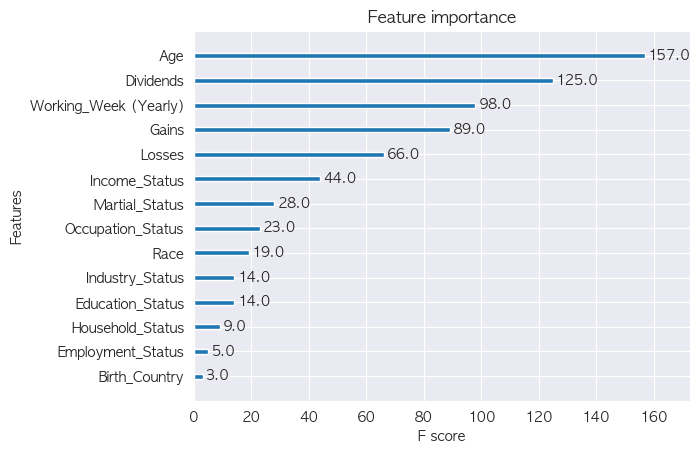

In [442]:
# 학습된 XGBoost 모델에서 feature importance를 추출
xgb.plot_importance(model)
plt.show()

# 최종 예측

In [443]:
preds = model.predict(scaled_test_df)

# 제출자료 생성

In [444]:
submission = pd.read_csv('data/sample_submission.csv')
submission['Income'] = preds
submission

,ID,Income
0,TEST_0000,-0.001745
1,TEST_0001,0.012335
2,TEST_0002,0.048576
3,TEST_0003,0.068588
4,TEST_0004,0.000462
...,...,...
9995,TEST_9995,0.074597
9996,TEST_9996,0.070694
9997,TEST_9997,0.033031
9998,TEST_9998,0.000804


In [445]:
current_datetime = datetime.datetime.now()
file_name = f'submission_{current_datetime.strftime("%Y%m%d_%H%M")}.csv'

In [446]:
submission.to_csv('result/'+file_name, index=False)